In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from sklearn.pipeline import Pipeline
import util
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from ds_library.data_preprocessing.data_loader.data_loader_train_test import DataLoaderTrainTest
from ds_library.data_preprocessing.preprocessor_train_test import EspecificPreprossessorTrainTest
from ds_library.data_preprocessing.data_loader.data_loader_from_txt import DataLoaderFromTXT
import turbofan_engine.constants as const_turbofan
from turbofan_engine.data_preprocessing.rul_calculator.calc_rul_train import CalcRULTrain
from turbofan_engine.data_preprocessing.rul_calculator.calc_rul_test import CalcRULTest
from turbofan_engine.data_preprocessing.rul_calculator.rul_config import RULConfig
from turbofan_engine.data_preprocessing.rul_calculator.rul_merge import DataFrameMerger
from turbofan_engine.data_preprocessing.rul_calculator.rul_calculator import DefaultRULCalculator
from turbofan_engine.data_preprocessing.rul_calculator.rul_filter import RULFilter, RULFilterTwo
from ds_library.data_preprocessing.normalizer_standard_scaler import NormStandardScaler

# Data

In [2]:
FEATURES_NAME = const_turbofan.FEATURES_NAME

FEATURES_TO_REMOVE = [const_turbofan.FEATURE_UNIT_NUMBER]

TARGET = const_turbofan.TARGET

In [3]:
dataLoader = DataLoaderTrainTest(train_path=const_turbofan.RAW_PATH_FD001_TRAIN,
                                 test_path=const_turbofan.RAW_PATH_FD001_TEST,
                                 features_name=FEATURES_NAME).load_dataset()

In [4]:
X_train, X_test, y_train, y_test = EspecificPreprossessorTrainTest(
    transformers_train=Pipeline([(const_turbofan.CalcRULTrain, CalcRULTrain()),
                                 (const_turbofan.RULFilter, RULFilter())]),
    transformers_test=Pipeline([
        (const_turbofan.CalcRULTest, 
         CalcRULTest(rul_calculator=DefaultRULCalculator(),
                     merger=DataFrameMerger(),
                     df_rul=DataLoaderFromTXT(
                         path_dataset_txt=const_turbofan.RAW_PATH_FD001_RUL,
                         features_name=[const_turbofan.DEFAULT_MAX_NAME]).load_dataset(),
                     config=RULConfig(
                         feature_unit_number=const_turbofan.FEATURE_UNIT_NUMBER, 
                         feature_time=const_turbofan.FEATURE_TIME, 
                         target=const_turbofan.TARGET, 
                         default_max_name=const_turbofan.DEFAULT_MAX_NAME, 
                         total_rul=const_turbofan.TOTAL_RUL)
         )
        ),
        (const_turbofan.RULFilter, RULFilterTwo())
    ]),
    features_to_remove=FEATURES_TO_REMOVE,
    target=TARGET).preprocess(dataLoader)

In [25]:
scaler = NormStandardScaler(FEATURES_NAME[1:])
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [26]:
gaf = GramianAngularField(flatten=False)

X_train_new = gaf.fit_transform(X_train)

X_test_new = gaf.transform(X_test)

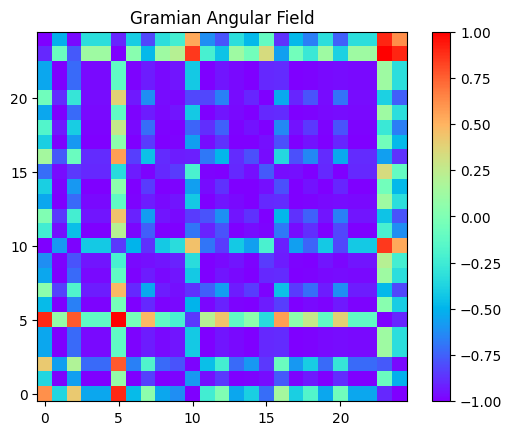

In [27]:
plt.imshow(X_train_new[0], cmap='rainbow', origin='lower')
plt.colorbar()
plt.title('Gramian Angular Field')
plt.show()

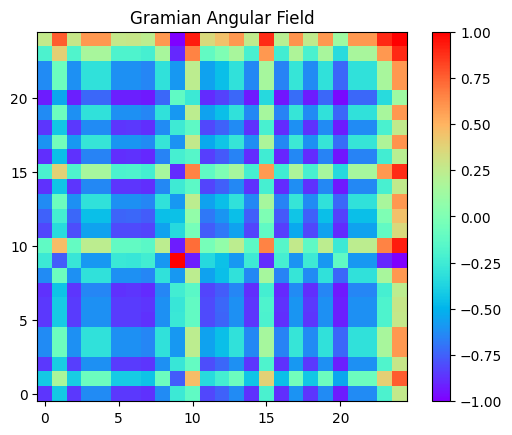

In [28]:
plt.imshow(X_train_new[200], cmap='rainbow', origin='lower')
plt.colorbar()
plt.title('Gramian Angular Field')
plt.show()

In [29]:
X_train_new_new, X_val, y_train_new_new, y_val = \
    train_test_split(X_train_new,
                     y_train,
                     test_size = 0.1,
                     stratify = None,
                     random_state = 42)

# Model

In [30]:
def create_tiled_cnn(input_shape):
    model = models.Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), 
                            padding='same', activation='relu', input_shape=input_shape))

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), 
                            padding='same', activation='relu'))

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), 
                            padding='same', activation='relu'))

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation='relu'))

    model.add(layers.Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

In [31]:
model = create_tiled_cnn((25, 25, 1))

In [32]:
X_train_new_new.shape

(18567, 25, 25)

In [33]:
checkpoint_callback = ModelCheckpoint('best_model.h5', 
                                      monitor='val_mae',
                                      save_best_only=True,
                                      mode='min',
                                      verbose=1)

history = model.fit(X_train_new_new, y_train_new_new, 
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=32,
                    callbacks=[checkpoint_callback])

Epoch 1/200
570/581 [============================>.] - ETA: 0s - loss: 2492.6685 - mae: 43.1721
Epoch 1: val_mae improved from inf to 36.37901, saving model to best_model.h5
581/581 [==============================] - 4s 6ms/step - loss: 2477.9666 - mae: 43.0186 - val_loss: 1827.6345 - val_mae: 36.3790
Epoch 2/200
573/581 [============================>.] - ETA: 0s - loss: 1595.3425 - mae: 33.4923
Epoch 2: val_mae improved from 36.37901 to 31.63077, saving model to best_model.h5
581/581 [==============================] - 4s 6ms/step - loss: 1593.5317 - mae: 33.4776 - val_loss: 1428.8610 - val_mae: 31.6308
Epoch 3/200
579/581 [============================>.] - ETA: 0s - loss: 1197.0098 - mae: 28.3614
Epoch 3: val_mae improved from 31.63077 to 26.37561, saving model to best_model.h5
581/581 [==============================] - 3s 6ms/step - loss: 1196.3348 - mae: 28.3506 - val_loss: 1065.7390 - val_mae: 26.3756
Epoch 4/200
577/581 [============================>.] - ETA: 0s - loss: 898.9315 -

In [34]:
predictions = model.predict(X_test_new)

235/235 [==============================] - 0s 2ms/step


In [35]:
mean_absolute_error(y_test, predictions)

22.918791841393514